In [ ]:
"""
Jana Casals Puy
jc4919

Emotion Recognition Project
"""

In [6]:
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: fer2013/train/angry/Training_81541574.jpg  
  inflating: __MACOSX/fer2013/train/angry/._Training_81541574.jpg  
  inflating: fer2013/train/angry/Training_50120123.jpg  
  inflating: __MACOSX/fer2013/train/angry/._Training_50120123.jpg  
  inflating: fer2013/train/angry/Training_60016886.jpg  
  inflating: __MACOSX/fer2013/train/angry/._Training_60016886.jpg  
  inflating: fer2013/train/angry/Training_68690730.jpg  
  inflating: __MACOSX/fer2013/train/angry/._Training_68690730.jpg  
  inflating: fer2013/train/angry/Training_73515932.jpg  
  inflating: __MACOSX/fer2013/train/angry/._Training_73515932.jpg  
  inflating: fer2013/train/angry/Training_32153813.jpg  
  inflating: __MACOSX/fer2013/train/angry/._Training_32153813.jpg  
  inflating: fer2013/train/angry/Training_57743136.jpg  
  inflating: __MACOSX/fer2013/train/angry/._Training_57743136.jpg  
  inflating: fer2013/train/angry/Training_15933141.jpg  
  inflating: __MA

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import glob 
import itertools
from PIL import Image
import math

cudnn.benchmark = True
plt.ion()   # interactive mode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [136]:
# Let’s visualize a few training images so as to understand the data augmentations.
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [137]:
def collate_fn(batch):
    # Filter failed images first
    batch = list(filter(lambda x: x is not None, batch))
    
    # Now collate into mini-batches
    images = torch.stack([b[0] for b in batch])
    labels = torch.LongTensor([b[1] for b in batch])
    
    return images, labels

In [90]:
# Now, let’s write a general function to train a model. 
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

In [165]:
#train_kfold method which implements k-fold cross validation
#defaults to k=3

#Algorithm:
#split train dataset into 1/k
#for data_fold in data split
#create val dataset from remaining val info
#set up model with new datasets
#run train_model() with current model
#save the model returned by train_model() if currently best acc


def train_kfold(model_k, k=3):

  best_model_wts = None
  best_acc = 0.0
  best_fold=0

  #get fold list for splitting training data
  folds=[]
  for i in range(k):
    folds.append(1/k)

  #split data into batches of 1/k size
  subsets=torch.utils.data.random_split(image_datasets['train'], folds)

  avg_acc=0.0
  for fold in range(0, k):
    print("Fold: " + str(fold) + "/" + str(k-1) + "")

    #set corresponding subsets to val or train
    folded_val=subsets[fold]
    folded_train=torch.utils.data.ConcatDataset(subsets[0:fold]+subsets[fold+1:k])

    folded_datasets={'train': folded_train, 'val': folded_val}

    #load data
    dataloaders = {x: torch.utils.data.DataLoader(folded_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0, collate_fn=collate_fn)
                for x in ['train', 'val']}

    dataset_sizes = {x: len(folded_datasets[x]) for x in ['train', 'val']}

    #train model
    model_folded, model_acc = train_model(model_k, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes,
                        num_epochs=10)
  
    if model_acc>best_acc:
      best_model_wts = model_folded
      best_acc=model_acc
      best_fold=(fold/k)

    avg_acc+=best_acc

  #return best model
  print("AVERAGE ACC: " + str(avg_acc/k))
  return best_model_wts




In [148]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(96),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(96),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(96),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [149]:
#Set up dataset + dataloader for FER2013 train and test

data_dir='./fer2013'
image_datasets={x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                for x in ['train', 'test']}
print(len(image_datasets['train'][0]))

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0, collate_fn=collate_fn)
              for x in ['train', 'test']}

2


In [150]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

{'train': 28709, 'test': 7178}
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([4, 3, 96, 96])
torch.Size([3, 100, 394])


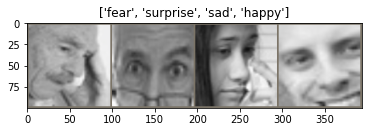

torch.Size([3, 96, 96])
0
28709


In [151]:
print(type(dataloaders['train']))
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape)
#print(classes)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(out.shape)

imshow(out, title=[class_names[x] for x in classes])

print(image_datasets['train'][0][0].shape)
print(image_datasets['train'][0][1])
print(len(image_datasets['train']))
#for image in image_datasets['train']:
#    print(image[0][0].shape)

In [152]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [153]:
# Load a pretrained model and reset final fully connected layer for this particular classification problem.
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 7)
#model_ft = nn.Sequential(*list(model_ft.children())[:-1])

# Move the model to the correct device (when we have access to a GPU)
model_ft = model_ft.to(device)

In [154]:
# Let's set our loss function
criterion = nn.CrossEntropyLoss()

In [155]:
# Setup the optimizer to update the model parameters
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [156]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [80]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                print("actual: " + str(labels[j]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [79]:
# Train and evaluate based on 1/3 val, 2/3 train split of train dataset 

folded_val, folded_train=torch.utils.data.random_split(image_datasets['train'], [1/3, 2/3])

folded_datasets={'train': folded_train, 'val': folded_val, 'test': image_datasets['test']}

dataloaders = {x: torch.utils.data.DataLoader(folded_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0, collate_fn=collate_fn)
                for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(folded_datasets[x]) for x in ['train', 'val', 'test']}

model_ft, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 1.8271 Acc: 0.3067
val Loss: 1.5083 Acc: 0.4222
Epoch 1/19
----------
train Loss: 1.5932 Acc: 0.3908
val Loss: 1.4403 Acc: 0.4456
Epoch 2/19
----------
train Loss: 1.5122 Acc: 0.4226
val Loss: 1.4548 Acc: 0.4269
Epoch 3/19
----------
train Loss: 1.4646 Acc: 0.4410
val Loss: 1.4914 Acc: 0.4290
Epoch 4/19
----------
train Loss: 1.4261 Acc: 0.4585
val Loss: 1.3745 Acc: 0.4664
Epoch 5/19
----------
train Loss: 1.3947 Acc: 0.4721
val Loss: 1.2521 Acc: 0.5289
Epoch 6/19
----------
train Loss: 1.3834 Acc: 0.4746
val Loss: 1.2354 Acc: 0.5290
Epoch 7/19
----------
train Loss: 1.2431 Acc: 0.5253
val Loss: 1.2061 Acc: 0.5376
Epoch 8/19
----------
train Loss: 1.2100 Acc: 0.5448
val Loss: 1.2111 Acc: 0.5398
Epoch 9/19
----------
train Loss: 1.2121 Acc: 0.5410
val Loss: 1.1932 Acc: 0.5504
Epoch 10/19
----------
train Loss: 1.2036 Acc: 0.5375
val Loss: 1.1983 Acc: 0.5511
Epoch 11/19
----------
train Loss: 1.1951 Acc: 0.5447
val Loss: 1.1825 Acc: 0.5551
Epoch 12/19
--

In [146]:
# Load a pretrained model and reset final fully connected layer.
model_k = models.resnet18(pretrained=True)

num_ftrs = model_k.fc.in_features

# nn.Linear(num_ftrs, len(class_names)=7).
model_k.fc = nn.Linear(num_ftrs, 7)

# Move the model to the correct device (when we have access to a GPU)
model_k = model_ft.to(device)

#loss function
criterion_k = nn.CrossEntropyLoss()

#optimizer + learning rate
optimizer_k = optim.SGD(model_k.parameters(), lr=0.001, momentum=0.9)

#scheduler
exp_lr_scheduler_k = lr_scheduler.StepLR(optimizer_k, step_size=7, gamma=0.1)

#run train_kfold with k=3 to implement 3-Fold Cross Validation
model_k3=train_kfold(model_k3)

Fold: 0/3
Epoch 0/9
----------
train Loss: 1.1688 Acc: 0.5541
val Loss: 1.1291 Acc: 0.5763
Epoch 1/9
----------
train Loss: 1.1776 Acc: 0.5512
val Loss: 1.1185 Acc: 0.5793
Epoch 2/9
----------
train Loss: 1.1704 Acc: 0.5527
val Loss: 1.1209 Acc: 0.5768
Epoch 3/9
----------
train Loss: 1.1711 Acc: 0.5544
val Loss: 1.1329 Acc: 0.5749
Epoch 4/9
----------
train Loss: 1.1680 Acc: 0.5535
val Loss: 1.1286 Acc: 0.5786
Epoch 5/9
----------
train Loss: 1.1724 Acc: 0.5537
val Loss: 1.1256 Acc: 0.5791
Epoch 6/9
----------
train Loss: 1.1694 Acc: 0.5540
val Loss: 1.1118 Acc: 0.5820
Epoch 7/9
----------
train Loss: 1.1720 Acc: 0.5559
val Loss: 1.1262 Acc: 0.5798
Epoch 8/9
----------
train Loss: 1.1676 Acc: 0.5542
val Loss: 1.1178 Acc: 0.5830
Epoch 9/9
----------
train Loss: 1.1712 Acc: 0.5538
val Loss: 1.1331 Acc: 0.5751
Training complete in 15m 55s
Best val Acc: 0.582968
Fold: 1/3
Epoch 0/9
----------
train Loss: 1.1695 Acc: 0.5557
val Loss: 1.1384 Acc: 0.5825
Epoch 1/9
----------
train Loss: 1.16

In [164]:
# Load a pretrained model and reset final fully connected layer.
model_k = models.resnet18(pretrained=True)

num_ftrs = model_k.fc.in_features

# nn.Linear(num_ftrs, len(class_names)=7).
model_k.fc = nn.Linear(num_ftrs, 7)

# Move the model to the correct device (when we have access to a GPU)
model_k = model_ft.to(device)

#loss function
criterion_k = nn.CrossEntropyLoss()

#optimizer + learning rate
optimizer_k = optim.SGD(model_k.parameters(), lr=0.001, momentum=0.9)

#scheduler
exp_lr_scheduler_k = lr_scheduler.StepLR(optimizer_k, step_size=7, gamma=0.1)

model_k5=train_kfold(model_k, k=5)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold: 0/5
Epoch 0/9
----------


KeyboardInterrupt: ignored

actual: tensor(0, device='cuda:0')


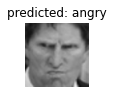

actual: tensor(0, device='cuda:0')


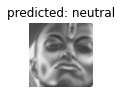

actual: tensor(5, device='cuda:0')


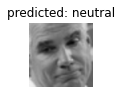

actual: tensor(3, device='cuda:0')


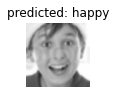

actual: tensor(3, device='cuda:0')


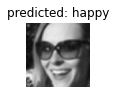

actual: tensor(3, device='cuda:0')


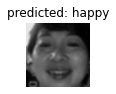

In [163]:
visualize_model(model_k5, num_images=6)